# Exercise 2.2

Consider the dataset `Ames`$^1$ from `R` package _modeldata_. Split the dataset in training and test subset, fit a linear regressive model with a arbitrarily chosen output (usually `Sale_Price`) and estimate the test error. Analyse the trend of test error when training and test set are split in different proportions. You may drop the categorical variables for simplicity, if you wish.

---

$^1$ Earlier versions of this set of exercises used the dataset `Boston` from package MASS. This turned out to be not a good idea from an ethical point of view, see for instance https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8.

## Preamble

In [ ]:
import numpy  as np     # array and random
import pandas as pd     # tabular data

# models
from sklearn.linear_model     import LinearRegression
from sklearn.model_selection  import train_test_split
from sklearn.metrics          import mean_squared_error

# graphics
from matplotlib.pyplot import subplots


# fix random seed for reproducibility
rng  = np.random.default_rng(2025)
seed = int(rng.integers(0, 2**31))    # generate random seed

## Load data

The `Ames` dataset can be imported from:
- the "official" `R` [package](https://github.com/topepo/AmesHousing/) (needs to be converted from `.rda`)
- community-maintained [CSV](https://github.com/EAISI/discover-projects/tree/main/ames-housing)
- [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
) (via Kaggle API or `wget`)

I choose the second option.

In [ ]:
ames_url = "https://raw.githubusercontent.com/eaisi/discover-projects/main/ames-housing/AmesHousing.csv"
data = pd.read_csv(ames_url)

Inspect the first rows.

In [ ]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
data.shape

(2930, 82)

## Preprocessing

I choose to drop the categorical variables.

In [ ]:
target = "SalePrice"
y = data[target]    # choose output variable

data_num = data.select_dtypes(include=[np.number])    # keep only numerical columns
X = data_num.drop(columns=[target])                   # removes target from predictors

X = X.dropna()      # drop missing values
y = y[X.index]

In [ ]:
X.shape

(2274, 38)

## Execution

Try different split proportions, train and test the model, plot the results.

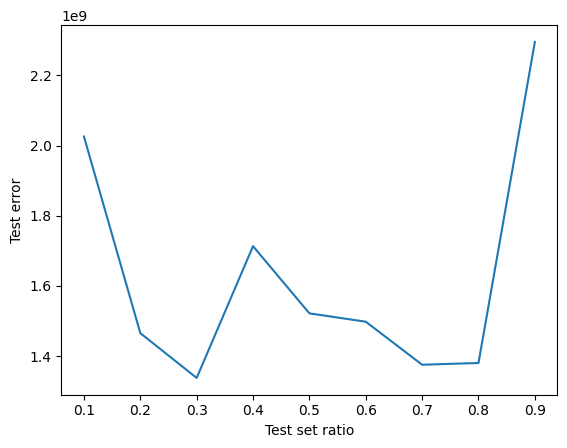

In [ ]:
#seed = int(rng.integers(0, 2**31))
test_ratios = np.linspace(0.1, 0.9, 9)    # 10%, ..., 90%

errors = []
for tr in test_ratios:
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=tr, random_state=seed )

  model = LinearRegression().fit(X_train, y_train)
  y_pred = model.predict(X_test)
  err = mean_squared_error(y_test, y_pred)
  errors.append(err)


fig, ax = subplots()
ax.plot(test_ratios, errors)
ax.set_xlabel("Test set ratio")
ax.set_ylabel("Test error")
fig;

There doesn't seem to be a robust relationship between split proportions and test error, as we can see by changing the random seed \
(just uncomment the first line and rerun the cell instead of the whole notebook).

This is not surprising if we look at the error magnitude: the data is manifestly not linear! \
Thus it makes sense that by changing the split, we see so much variability.



# Exercise 2.7

Consider the dataset `Ames` from `R` package _modeldata_ through linear regression.
- Compute training and test error of _hold out set_ validation evaluated on random samples of the training/validation sets.
- Compute training and test error of LOO-CV.
- Compute training and test error of $k$-fold CV, for different values of $k$.

## Preamble

In [ ]:
# cross validation packages
from sklearn.model_selection import (
    LeaveOneOut,
    KFold,
    cross_validate,
)

## Setup

Define functions for the three cross validation methods. \
The training pool is splitted in training and validation sets, the model with the best performance on the validation set is chosen.

We use `cross_validate` to automate the split + fit + score steps. \
Notice that this function returns negative MSE (by convention higher = better), so we need to flip the sign.

Holdout is repeated multiple times and then averaged to reduce variance.

In [ ]:
def best_model(results):
  '''
  Return best model and its training and validation errors.
  results : dictionary with keys 'models', 'train_errors', 'val_errors'
  '''
  best_idx = np.argmin(results['val_errors'])   # minimize validation error
  return  results['models'      ][best_idx], \
          results['train_errors'][best_idx], \
          results['val_errors'  ][best_idx]

In [ ]:
def repeated_holdout(X_pool, y_pool, val_ratio=0.5, n_repeats=10):
  results = {'models': [], 'train_errors': [], 'val_errors': []}

  for _ in range(n_repeats):
    X_train, X_val, y_train, y_val = train_test_split(
        X_pool, y_pool, test_size=val_ratio, random_state=seed )

    model = LinearRegression().fit(X_train, y_train)
    results['models']      .append(model)
    results['train_errors'].append(mean_squared_error(y_train, model.predict(X_train)))
    results['val_errors']  .append(mean_squared_error(y_val  , model.predict(X_val  )))

  return best_model(results)


def loo_cv(X_pool, y_pool):
  cv = LeaveOneOut()
  cv_results = cross_validate(
      LinearRegression(), X_pool, y_pool,
      cv = cv,
      scoring = 'neg_mean_squared_error',
      return_train_score = True,
      return_estimator   = True,
  )

  results = {
      'models'      :  cv_results['estimator'],
      'train_errors': -cv_results['train_score'],
      'val_errors'  : -cv_results['test_score'],
  }
  return best_model(results)


def kfold_cv(X_pool, y_pool, k):
  cv = KFold(
      n_splits     = k,
      shuffle      = True,
      random_state = seed
  )
  cv_results = cross_validate(
      LinearRegression(), X_pool, y_pool,
      cv = cv,
      scoring = 'neg_mean_squared_error',
      return_train_score = True,
      return_estimator   = True,
  )

  results = {
      'models'      :  cv_results['estimator'],
      'train_errors': -cv_results['train_score'],
      'val_errors'  : -cv_results['test_score'],
  }
  return best_model(results)

## Execution

Split training pool (for training and validation) and test set.

In [ ]:
X_pool, X_test, y_pool, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed )

In [ ]:
# use a template to print aligned columns
template = "{label:<12} train MSE = {tr:.2e},\t val MSE = {va:.2e},\t test MSE = {te:.2e}"

def printfun(label, best_model):
  model, train_err, val_err = best_model
  test_err = mean_squared_error(y_test, model.predict(X_test))

  print(template.format(label = label + ":",
                        tr = train_err, va = val_err, te = test_err
                       ))

In [ ]:
printfun("holdout", repeated_holdout(X_pool, y_pool))

ks = [2, 5, 10, 100, 1000]
for k in ks:
  printfun(f"{k}-fold", kfold_cv(X_pool, y_pool, k))

printfun("loo-cv", loo_cv(X_pool, y_pool))

holdout:     train MSE = 1.08e+09,	 val MSE = 1.20e+09,	 test MSE = 1.44e+09
2-fold:      train MSE = 1.08e+09,	 val MSE = 1.20e+09,	 test MSE = 1.44e+09
5-fold:      train MSE = 1.16e+09,	 val MSE = 8.14e+08,	 test MSE = 1.35e+09
10-fold:     train MSE = 1.13e+09,	 val MSE = 7.06e+08,	 test MSE = 1.35e+09
100-fold:    train MSE = 1.09e+09,	 val MSE = 2.39e+08,	 test MSE = 1.34e+09
1000-fold:   train MSE = 1.09e+09,	 val MSE = 2.99e+03,	 test MSE = 1.34e+09
loo-cv:      train MSE = 1.09e+09,	 val MSE = 2.99e+03,	 test MSE = 1.34e+09


# Exercise 2.8

Consider the dataset `Ames` from `R` package _modeldata_ through linear regression (output of your choice). Find the _learning curve_ with an estimate of the test error obtained through _hold out set_ validation, LOO-CV, $k$-fold CV and bootstrap.

## Preamble

In [ ]:
from functools import partial

## Setup

Define bootstrap function. Evaluation is performed on the out-of-bag sample points.

In [ ]:
def bootstrap(X_pool, y_pool, n_boot=50):
  results = {'models': [], 'train_errors': [], 'val_errors': []}
  n = len(X_pool)

  for _ in range(n_boot):
    # sample bootstrap indices (with replacement)
    boot_idx = rng.choice(n, size=n, replace=True)

    # identify out‑of‑bag (OOB) indices
    mask = np.ones(n, dtype=bool)
    mask[boot_idx] = False
    oob_idx = np.nonzero(mask)[0]

    # skip if no OOB
    if oob_idx.size == 0:
        continue

    X_train, y_train = X_pool.iloc[boot_idx], y_pool.iloc[boot_idx]
    X_val  , y_val   = X_pool.iloc[oob_idx],  y_pool.iloc[oob_idx]

    model = LinearRegression().fit(X_train, y_train)
    results['models']      .append(model)
    results['train_errors'].append(mean_squared_error(y_train, model.predict(X_train)))
    results['val_errors']  .append(mean_squared_error(y_val  , model.predict(X_val  )))

  return best_model(results)

## Execution

Warning: it will take a while to run this cell.

In [ ]:
n = len(X_pool)
train_fracs = np.linspace(0.1, 1, 10)     # 10%, 20%, ..., 100%
train_sizes = (train_fracs * n).astype(int)

methods = [
    ("Hold‑out",   repeated_holdout),
    ("2‑fold CV",  partial(kfold_cv, k=2)),
    ("5‑fold CV",  partial(kfold_cv, k=5)),
    ("10‑fold CV", partial(kfold_cv, k=10)),
    ("LOO‑CV",     loo_cv),
    ("Bootstrap",  partial(bootstrap, n_boot=50)),
]

results = {name: {'train_err': [], 'val_err': []} for name, *_ in methods}


for m in train_sizes:
    # draw a random subset of size m from the pool
    idx = rng.choice(n, size=m, replace=False)
    X_sub = X_pool.iloc[idx]
    y_sub = y_pool.iloc[idx]

    for name, func in methods:
      _, train_err, val_err = func(X_sub, y_sub)
      results[name]['train_err'].append(train_err)
      results[name]['val_err']  .append(val_err)

## Plot

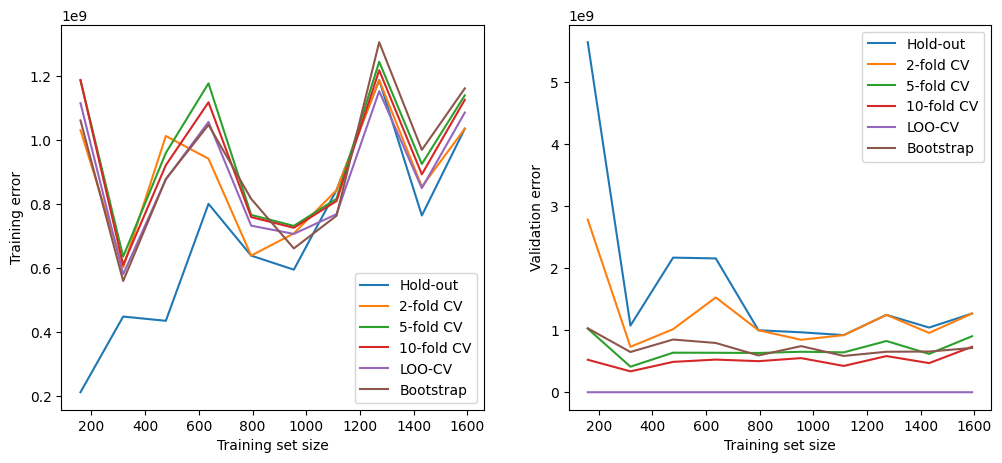

In [ ]:
fig, (axl, axr) = subplots(ncols=2, figsize=(12,5))

for name, _ in methods:
  axl.plot(train_sizes, results[name]['train_err'], label=name)
  axr.plot(train_sizes, results[name]['val_err']  , label=name)

axl.set_xlabel("Training set size")
axl.set_ylabel("Training error")
axl.legend()
axr.set_xlabel("Training set size")
axr.set_ylabel("Validation error")
axr.legend();

As expected, training curves tend to get higher and validation ones get lower as training size increases (though they are quite jagged).